# Enhanced model for recommendation system

Outline:
1. Database connection. Data preprocessing. #postgresql
2. Feature extraction from unlabeled text. 

    2.1 Extract and handle BERT embeddings #bert 

    2.2 Clusterize embeddings #pca #kmeans #dec #nlpaugmentation (TODO: #idec)
3. Model training and evaluating #catboost

    3.1 Default catboost

    3.2 TODO: Tuned catboost
4. Model saving and feature uploading to server

Intro:

Recently I found an interesting [paper by Subakti et al. (2022)](https://journalofbigdata.springeropen.com/articles/10.1186/s40537-022-00564-9), which relates to the problem of BERT embeddings clusterization. In paper, there are several proposed strategies: proper BERT embeddings handling (pooling&normalization) combined with different techniques, such as KMeans, DEC (Deep Embedded Clustering), IDEC (Improved DEC), fuzzy C-Means. I tried to play with DEC&IDEC because they had the best performance (see Subakti's paper). Unfortunately, there was no acceptable pytorch implementation, so I rewrote existing solutions and applied rewritten DEC and IDEC for current task. *See [my DEC/IDEC_mnist repo](https://github.com/grokhi/pytorch_DEC_IDEC_2022) for details*

tl;dr:
- Deep Embedded Clustering (DEC) trained on augmented dataset showed 92% cluster accuracy (b/line kmeans 58%). Extracted features were used for catboost training
- Unfortunately, default catboost model (.65) showed less ROC-AUC score than in base model (.67). Need to tune it
- Tuned catboost results: #TODO.

TODO: What's next? Obtained results from base_model and enhanced_model will be validated using scheduling A/B tests on a local server. #abtests #airflow #docker #postgresql *See [file-not-yet-ready] for details*

## 1. Connect to DB

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

CONN = "postgresql://robot-startml-ro:pheiph0hahj1Vaif@"\
    "postgres.lab.karpov.courses:6432/startml"

In [3]:
# User data

user_info = pd.read_sql(
    """SELECT * FROM public.user_data""",
    con=CONN
)

# user_info = pd.read_csv('data/user_info.csv', index_col=0)
print(user_info.shape)
user_info.sample(5)

(163205, 8)


,user_id,gender,age,country,city,exp_group,os,source
107715,113045,1,29,Russia,Volkhov,4,Android,organic
82279,86188,0,18,Russia,Astrakhan,2,Android,ads
17333,17543,1,19,Russia,Samara,4,Android,ads
133203,138532,1,33,Russia,Krasnogorsk,4,Android,organic
158839,164184,1,22,Russia,Penza,0,Android,organic


In [4]:
# Posts and topics

posts_info = pd.read_sql(
    """SELECT * FROM public.post_text_df""",
    con=CONN
)

# posts_info = pd.read_csv('data/posts_info.csv', index_col=0)

print(posts_info.shape)
posts_info.sample(5)

(7023, 3)


,post_id,text,topic
143,286,Air Jamaica back in state control\n\nThe Jamai...,business
1694,1381,Fuming Robinson blasts officials\n\nEngland co...,sport
1960,1604,Prutton poised for lengthy FA ban\n\nSouthampt...,sport
576,507,Deadline nears for Fiat-GM deal\n\nFiat and Ge...,business
5334,5553,The movie deserves 2/10. 1.5 stars for the gir...,movie


In [5]:

feed_data = pd.read_sql(
    """SELECT * FROM public.feed_data LIMIT 1000000""",
    con=CONN
)

# feed_data = pd.read_csv('data/feed_data.csv', index_col=0)

# remove likes
feed_data = feed_data[feed_data.action == 'view']

print(feed_data.shape)
feed_data.sample(5)

(894745, 5)


,timestamp,user_id,post_id,action,target
900431,2021-10-16 19:06:22,118307,7135,view,1
324323,2021-11-22 09:18:04,124112,2577,view,0
387505,2021-12-03 13:37:06,150700,4015,view,0
444046,2021-12-10 13:06:41,54750,1354,view,0
898151,2021-10-05 07:55:40,54870,5274,view,0


# 2. Feature preprocessing

## 2.1 posts_info.text feature extraction using BERT

### 2.1a Getting BERT embeddings

In [6]:
# let's map text to embedding
from transformers import AutoTokenizer
# https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertModel
from transformers import BertModel


def get_model(model_name):
    assert model_name in ['bert_cased','bert_uncased',]

    checkpoint_names = {
        'bert_cased': 'bert-base-cased',  # https://huggingface.co/bert-base-cased
        'bert_uncased': 'bert-base-uncased',  # https://huggingface.co/bert-base-uncased
    }

    model_classes = {
        'bert_cased': BertModel,
        'bert_uncased': BertModel,
    }

    return (
        AutoTokenizer.from_pretrained(checkpoint_names[model_name]),
        model_classes[model_name].from_pretrained(checkpoint_names[model_name])
    )


In [7]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding


class PostDataset(Dataset):
    def __init__(self, texts, tokenizer):
        super().__init__()

        self.texts = tokenizer.batch_encode_plus(
            texts,
            add_special_tokens=True,
            return_token_type_ids=False,
            max_length=512,
            return_tensors='pt',
            truncation=True,
            padding=True
        )
        self.tokenizer = tokenizer

    def __getitem__(self, idx):
        return {'input_ids': self.texts['input_ids'][idx], 'attention_mask': self.texts['attention_mask'][idx]}

    def __len__(self):
        return len(self.texts['input_ids'])


def reload(values, tokenizer):
    dataset = PostDataset(values.tolist(), tokenizer)

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    loader = DataLoader(dataset, batch_size=32,
                        collate_fn=data_collator, pin_memory=True, shuffle=False)

    return (
        dataset, data_collator, loader
    )


In [8]:
import torch
from tqdm import tqdm


@torch.inference_mode()
def get_embeddings_labels(model, loader, device):  
    model.eval()
    model.to(device)
 
    total_embeddings = []

    for batch in tqdm(loader):
        batch = {key: batch[key].to(device)
                 for key in ['attention_mask', 'input_ids']}

        embeddings = model(**batch)['last_hidden_state'][:, :25, :] #as in paper Subakti (2022)

        total_embeddings.append(embeddings.cpu())

    return torch.cat(total_embeddings, dim=0)


In [9]:
tokenizer, model = get_model('bert_uncased')

dataset, data_collator, loader = reload(posts_info['text'].values, tokenizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
print(torch.cuda.get_device_name())

model = model.to(device)

cuda:0
NVIDIA GeForce GTX 1060 with Max-Q Design


In [10]:
embeddings = get_embeddings_labels(model, loader, device)

embeddings.shape

100%|██████████| 220/220 [09:09<00:00,  2.50s/it]


torch.Size([7023, 25, 768])

In [18]:
# save text and mapped numeric labels
map_dict = {topic: i for i, topic in enumerate(pd.Series(posts_info.topic.values).value_counts().index.sort_values())}
emb_num_labels = np.vectorize(map_dict.get)(posts_info.topic.values)

# np.save('bert_embeddings/embeddings_full.npy', embeddings)
# np.save('bert_embeddings/emb_txt_labels.npy', posts_info.topic.values)
# np.save('bert_embeddings/emb_num_labels.npy', emb_num_labels)

### 2.1b Feature extraction

According to Subakti (2022), different strategies of pooling and normalization may be appliable to the BERT outputs.

Pooling:

In [11]:
def pool_by_tokens(tensor:torch.Tensor, method:str):
    assert method in ['max_pooling', 'mean_pooling']
    _dict = {
        'max_pooling' : lambda tensor: torch.max(tensor, dim=1)[0],
        'mean_pooling' : lambda tensor: torch.mean(tensor, dim=1)
    }
    return _dict[method](tensor).numpy()
    

Normalization:

In [12]:
def normalization(array, method):
    assert method in ['identity', 'standard', 'layer', 'minmax']
    axis = 0
    _dict = {
        'identity' : lambda x: x,
        'standard' : lambda x: x / np.linalg.norm(x, axis=0),
        'layer' : lambda x: (x - x.mean(axis)) / x.std(axis),
        'minmax' : lambda x: (x - x.min(axis)) / (x.max(axis) - x.min(axis))
    }
    return _dict[method](array)

In [ ]:
# Getting dictionary with different combinations of extracted embeddings
embdict = {}
for pooling in ['max_pooling', 'mean_pooling']:
    array = pool_by_tokens(embeddings, pooling)
    for norm_method in ['identity', 'standard', 'layer', 'minmax' ]:
        embdict[pooling+'__'+norm_method] = normalization(array, norm_method)

np.save('bert_embeddings/embdict.npy', embdict)
# np.save('bert_embeddings/emb_meanpooling_layer.npy', embdict['mean_pooling__layer'])
np.save('bert_embeddings/emb_maxpooling_layer.npy', embdict['mean_pooling__layer'])
embdict.keys()        

According to my tests (*see DEC_BERT_embeddings.ipynb*), only 'layer normalization' (a.k.a. StandardScaler()) allows for smooth learning curve with the best behavior (high metrics + stable learning&performance curves)

In [15]:
# embdict = np.load('bert_embeddings/embdict.npy', allow_pickle=True).item()

# we derived that version as the best 
embeddings = embdict['mean_pooling__layer'] 

# possible alternative to 'mean_pooling__layer'
# embeddings = embdict['max_pooling__layer'] 

embeddings.shape

(7023, 768)

## 2.2 Applying different clusterization tecchniques (PCA, KMeans, DEC, DEC-aug)

In [12]:
# evaluate cluster accuracy using hungarian algorithm (finds most accurate combination b2n true and predicted labels)
from dec.utils import cluster_acc


In [14]:
# embeddings = torch.Tensor(
#     np.load('bert_embeddings\emb_meanpooling_layer.npy', allow_pickle=True)
# )


In [37]:
# funcs for vizualization
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler

def umap_reduce(arr):
    reducer = umap.UMAP()

    scaled = StandardScaler().fit_transform(arr)

    _umap = reducer.fit_transform(scaled)

    return pd.DataFrame({'x': _umap[:, 0], 'y': _umap[:, 1]})

def plot_labels(umap_df, legend:str, labeltext:bool=False):
    cmap = plt.cm.Set1
    norm = plt.Normalize(umap_df['label'].values.min(),
                        umap_df['label'].values.max())

    size = 10

    if labeltext:
        grouped=umap_df.groupby("labeltext")
    else:
        grouped=umap_df.groupby("label")

    for i, dff in grouped:
        plt.scatter(dff['x'], dff['y'], s=size, c=cmap(norm(dff['label'])),
                    edgecolors='none', label=f'{legend} {i}')

umap_df = umap_reduce(embeddings)

### 2.2a Removing noise from BERT embeddings using PCA decomposition

Rule of thumb: taking *n_components* that capture 90% of variance to reduce noise

In [16]:
from sklearn.decomposition import PCA
pca = PCA(n_components=.9, svd_solver='full') 
# +3%

centered = embeddings - embeddings.mean()
pca_decomp = pca.fit_transform(centered)

print('n_components =', pca_decomp.shape[1])

n_components = 257


### 2.2b Use KMeans clustering and visualize it (both w/ PCA) using UMAP projection

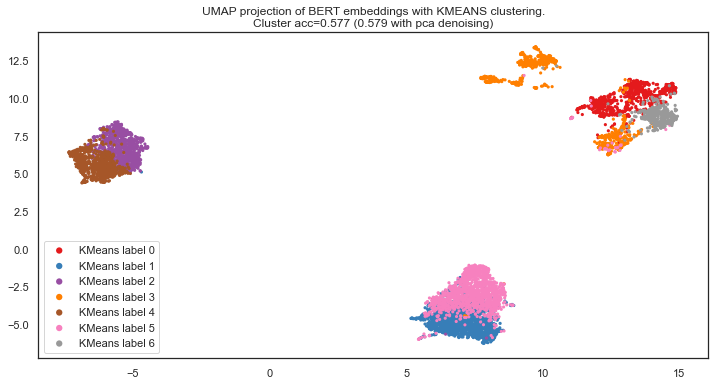

In [47]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=7, random_state=0, n_init=20).fit(embeddings)
posts_info['KMeansTextCluster'] = kmeans.labels_
umap_df['label'] = kmeans.labels_ 

cl_acc = round(cluster_acc(emb_num_labels, kmeans.labels_), 3)

kmeans_pca = KMeans(n_clusters=7, random_state=0, n_init=20).fit(pca_decomp)
umap_df['label'] = kmeans_pca.labels_ 
cl_acc_pca = round(cluster_acc(emb_num_labels, kmeans_pca.labels_), 3)

sns.set(style='white', context='notebook', rc={'figure.figsize': (12, 6)})
plt.title(f'UMAP projection of BERT embeddings with KMEANS clustering.\nCluster acc={cl_acc} ({cl_acc_pca} with pca denoising)')

plot_labels(umap_df, legend='KMeans label')

plt.legend(markerscale=2)
plt.show()

PCA denoising not making a big deal.

### 2.2c DEC/IDEC predictions (trained on original dataset n=7K)

In simple words, DEC is a trained fully-connected encoder with additional learning of KMeans centroids on kullback–leibler (KL) divergence. In theory (see my github mnist example), additional tuning of trained distribution should give 5-10% performance increase. In practice (see DEC_BERT_embeddings.ipynb), almost all increase in performance caused by trained encoder - it's very complicate to make KL loss work (some requirements on the dataset must be fullfilled). However, Training DEC on KL loss allows to catch additional precentages of performance. IDEC makes an imporvement by considering reconstruction MSE loss both with clustering KL loss. In some cases, such addition helps to prevent rapid performance curve decaying.

![DEC network arhitecture](dec.png)

In [69]:
dec_dct = np.load('dec\predictions\dec_results_dict.npy', allow_pickle=True).item()
dec_labeltext = np.load('dec\predictions\dec_textcluster.npy')

dec_dct.keys()

dict_keys(['accuracy', 'predicted', 'features'])

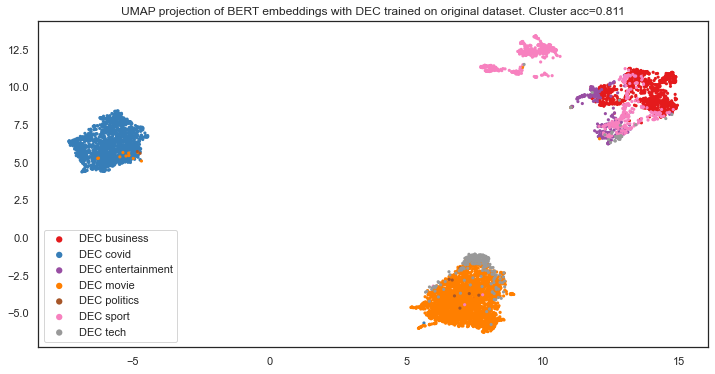

In [68]:
posts_info['DECTextCluster'] = dec_dct['predicted']
umap_df['label'] = dec_dct['predicted']
umap_df['labeltext'] = dec_labeltext

cl_acc = round(cluster_acc(emb_num_labels, dec_dct['predicted']), 3)

sns.set(style='white', context='notebook', rc={'figure.figsize': (12, 6)})
plt.title(f'UMAP projection of BERT embeddings with DEC trained on original dataset. Cluster acc={cl_acc}')

plot_labels(umap_df, legend='DEC', labeltext=True)

plt.legend(markerscale=2)
plt.show()

In [70]:
# sanity check
matched, total = 0, 0
for true, pred in zip(posts_info.topic.values, dec_labeltext):
    if true==pred:
        matched+=1
    total+=1
matched/total

0.8106222412074612

### 2.2d DEC/IDEC aug predictions (trained on augmented dataset n=70K)

We managed to get +20% performance (comparing to baseline KMeans) only by using autoencoders for the purposes of clusterization (DEC/IDEC). Let's make one step further and try to learn DEC/IDEC on the augmented dataset. For this purpose, let's use back translation technique for every text item (using pretrained [BERT-multilingual-uncased](https://huggingface.co/bert-base-multilingual-uncased)) and increase the dataset size by 10 times. *See DatasetAugmentation.ipynb and Train_BERTembedaug.ipynb for details*

In [84]:
idecaug_dct = np.load('dec_aug\idec_results_dict.npy', allow_pickle=True).item()
idecaug_labeltext = np.load('dec_aug\idec_textcluster.npy')

idecaug_dct.keys()

dict_keys(['accuracy', 'predicted', 'features', 'reassignment_dict'])

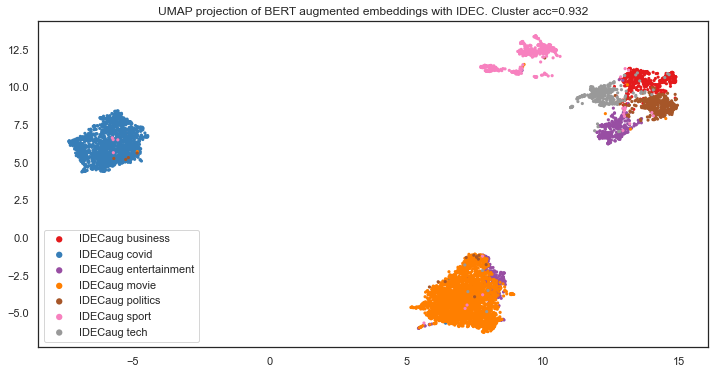

In [119]:
posts_info['IDECaugTextCluster'] = idecaug_dct['predicted']
umap_df['label'] = idecaug_dct['predicted']
umap_df['labeltext'] = idecaug_labeltext

cl_acc = round(cluster_acc(emb_num_labels, idecaug_dct['predicted']), 3)

sns.set(style='white', context='notebook', rc={'figure.figsize': (12, 6)})
plt.title(f'UMAP projection of BERT augmented embeddings with IDEC. Cluster acc={cl_acc}')

plot_labels(umap_df, legend='IDECaug', labeltext=True)

plt.legend(markerscale=2)
plt.show()

In [86]:
# sanity check
matched, total = 0, 0
for true, pred in zip(posts_info.topic.values, idecaug_labeltext):
    if true==pred:
        matched+=1
    total+=1
matched/total

0.9320803075608715

Amazing! We managed to get +30% (!) increase in cluster accuracy only by training IDEC on augmented dataset

## 2.3 Merging features for enchanced model

In [134]:
def get_features(method):
    features = {
        'kmeans': kmeans.transform(embeddings),
        'dec' : dec_dct['features'],
        'idec_aug' : idecaug_dct['features']
    }

    # data = methods[method](df) if method!=None else df

    data = features[method]

    if method=='dec':
        columns = [f'DECFeature{i}' for i in range(data.shape[1])]
    elif method=='idec_aug':
        columns = [f'IDECFeature{i}' for i in range(data.shape[1])]
        
    elif method=='kmeans':
        columns = [f"DistanceTo{i}thCluster" for i in range(0, data.shape[1])]

    return pd.DataFrame(
        data=data,
        columns=columns
    )

text_features = get_features('idec_aug')

text_features.sample(5)

,IDECFeature0,IDECFeature1,IDECFeature2,IDECFeature3,IDECFeature4,IDECFeature5,IDECFeature6
2107,0.021973,0.006397,0.939439,0.008794,0.006943,0.009064,0.007391
5100,0.887644,0.011621,0.031694,0.015827,0.022380,0.019138,0.011697
3520,0.072368,0.023816,0.781896,0.029255,0.025603,0.034312,0.032749
2087,0.010721,0.008125,0.011303,0.005249,0.012112,0.012819,0.939672
556,0.086087,0.159029,0.090391,0.072142,0.056917,0.421232,0.114202


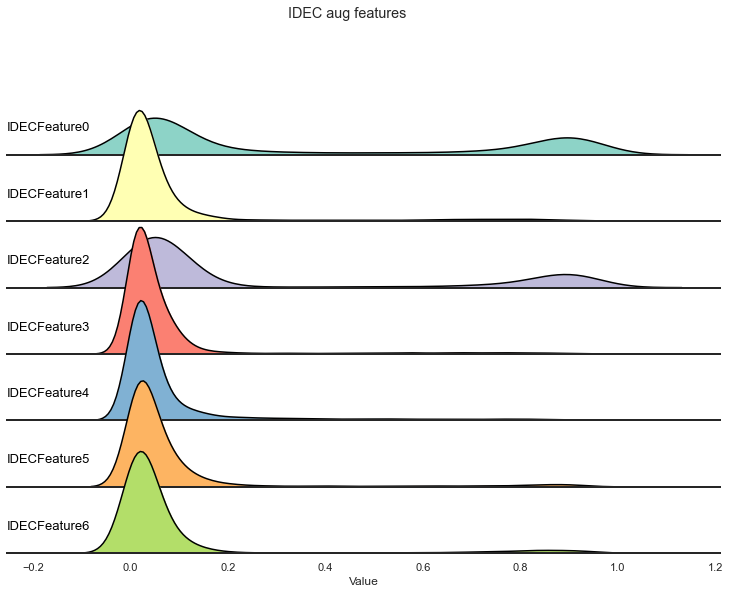

In [135]:
df_long = text_features.melt(var_name='Column', value_name='Value')

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})
palette = sns.color_palette("Set3", 12)
g = sns.FacetGrid(df_long, palette=palette, row="Column", hue="Column", aspect=9, height=1.2)
g.map_dataframe(sns.kdeplot, x="Value", fill=True, alpha=1)
g.map_dataframe(sns.kdeplot, x="Value", color='black')
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes)
    
g.map(label, "Value")
g.fig.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[], xlabel="Value", ylabel='')
g.despine( left=True)

plt.suptitle('IDEC aug features', y=0.98)
plt.show()

In [128]:
def merge_tables(feat_df):
    _posts_info = posts_info.join(feat_df)

    df = pd.merge(
        feed_data, _posts_info,
        on='post_id', 
        how='left'
    )

    df = pd.merge(
        df, user_info,
        on='user_id',
        how='left')

    ### Extract addtional features from timestamp

    df['hour'] = pd.to_datetime(df['timestamp']).apply(lambda x: x.hour)
    df['month'] = pd.to_datetime(df['timestamp']).apply(lambda x: x.month)

    ### remove unnescessary columns
    df = df.drop([
    #    'timestamp', 
        'action',
        'text',
        'topic', # because we do unsupervised learning
        'KMeansTextCluster', 'DECTextCluster',
       'IDECaugTextCluster',
    ],  
        axis=1)

    return df.set_index(['user_id', 'post_id'])

processed_df = merge_tables(text_features)
print(processed_df.shape)
processed_df.columns

(894745, 18)


Index(['timestamp', 'target', 'IDECFeature0', 'IDECFeature1', 'IDECFeature2',
       'IDECFeature3', 'IDECFeature4', 'IDECFeature5', 'IDECFeature6',
       'gender', 'age', 'country', 'city', 'exp_group', 'os', 'source', 'hour',
       'month'],
      dtype='object')

# 3. Model Training

## 3.1 Default catboost

In [129]:
max(processed_df.timestamp), min(processed_df.timestamp)

(Timestamp('2021-12-29 23:39:35'), Timestamp('2021-10-01 06:07:20'))

In [130]:
def prepare_data(df):
    ### Split by 2021-12-15

    df_train = df[df.timestamp < '2021-12-15']
    df_test = df[df.timestamp >= '2021-12-15']

    df_train = df_train.drop('timestamp', axis=1)
    df_test = df_test.drop('timestamp', axis=1)

    X_train = df_train.drop('target', axis=1)
    X_test = df_test.drop('target', axis=1)

    y_train = df_train['target']
    y_test = df_test['target']

    return X_train, y_train, X_test, y_test

In [131]:
### Default Catboost 
from catboost import CatBoostClassifier

catboost_dec_aug = CatBoostClassifier(task_type='GPU')

object_cols = [
    'gender', 'country',
    'city', 'exp_group', 'hour', 'month',
    'os', 'source'
]

X_train, y_train, X_test, y_test = prepare_data(processed_df)

catboost_dec_aug.fit(X_train, y_train, object_cols, verbose=False)

In [132]:
from sklearn.metrics import roc_auc_score

print(
    f"ROCAUC TRAIN: {roc_auc_score(y_train, catboost_dec_aug.predict_proba(X_train)[:, 1])}")
print(
    f"ROCAUC TEST: {roc_auc_score(y_test, catboost_dec_aug.predict_proba(X_test)[:, 1])}")


ROCAUC TRAIN: 0.6907799109488364
ROCAUC TEST: 0.6566583876933578


Unfortunately, there is no increase in the final metrics even with our great text clusterization. Actually, simple PCA decomposition showed much better results than our sophisticated approach. KISS, huh? :-)

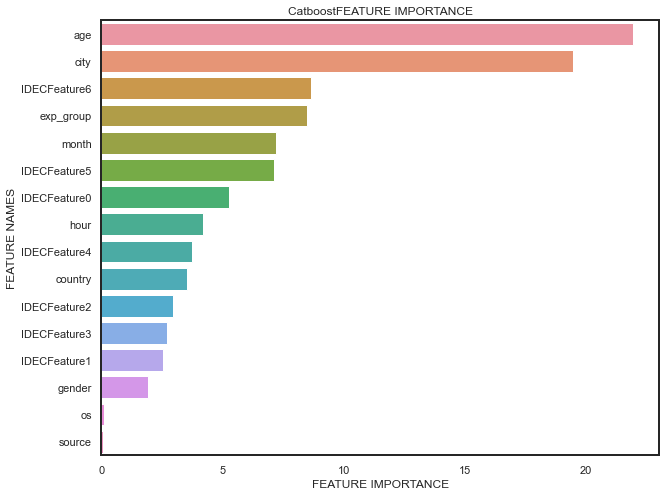

In [133]:
# feature_importance
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


def plot_feature_importance(importance, names, model_type):

    # Create arrays from feature importance and feature names
    feature_importance = np.array(importance)[:20]
    feature_names = np.array(names)[:20]

    # Create a DataFrame using a Dictionary
    data = {'feature_names': feature_names,
            'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)

    # Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    # Define size of bar plot
    plt.figure(figsize=(10, 8))
    # Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    # Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')


plot_feature_importance(catboost_dec_aug.feature_importances_,
                        X_train.columns, 'Catboost')


But we didn't tune our catboost yet! Maybe here is a key to a greater model performance?

## 3.2 Tuned catboost

#TODO

# 4. Upload new fetures to the database

In [136]:
posts_info.to_sql(
   "grokhi_enhanced_model_posts_info_features",
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml",
    schema="public",
    if_exists='replace'
   )


23

In [137]:
# test upload

test_ = pd.read_sql(
    """SELECT * FROM public.grokhi_enhanced_model_posts_info_features""",

    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
)

test_


,index,post_id,text,topic,KMeansTextCluster,DECTextCluster,IDECaugTextCluster
0,0,1,UK economy facing major risks\n\nThe UK manufa...,business,3,0,0
1,1,2,Aids and climate top Davos agenda\n\nClimate c...,business,2,4,4
2,2,3,Asian quake hits European shares\n\nShares in ...,business,3,0,0
3,3,4,India power shares jump on debut\n\nShares in ...,business,3,0,0
4,4,5,Lacroix label bought by US firm\n\nLuxury good...,business,3,0,0
...,...,...,...,...,...,...,...
7018,7015,7312,"Mario Lanza, of course, is The Great Caruso in...",movie,4,2,2
7019,7016,7313,"Oh God,what an idiotic movie!Incredibly cheap ...",movie,4,3,3
7020,7017,7314,Although the likeliness of someone focusing on...,movie,1,3,3
7021,7018,7315,"OK, I would not normally watch a Farrelly brot...",movie,1,3,3
